# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

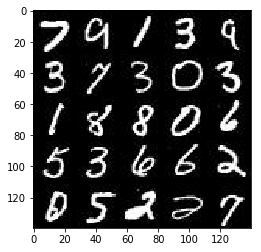

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

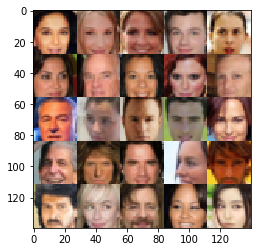

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        l3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(l3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):

        l1 = tf.layers.dense(z, 4*4*512)
        l1 = tf.reshape(l1, (-1, 4, 4, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        # 4x4x512 now
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 4, strides=1, padding='valid')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        # 7x7x256 now
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    total_data_size, image_width, image_height, image_channels = data_shape

    input_real, input_z, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Generate random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               learning_rate_input: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               learning_rate_input: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch Step {}...".format(epoch_i, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
                
        print('Done Training!')
        show_generator_output(sess, 20, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2 Batch Step 10... Discriminator Loss: 0.5206... Generator Loss: 1.1373
Epoch 0/2 Batch Step 20... Discriminator Loss: 0.0890... Generator Loss: 3.7613
Epoch 0/2 Batch Step 30... Discriminator Loss: 0.2740... Generator Loss: 12.1271
Epoch 0/2 Batch Step 40... Discriminator Loss: 0.1765... Generator Loss: 2.9249
Epoch 0/2 Batch Step 50... Discriminator Loss: 0.1677... Generator Loss: 2.6372
Epoch 0/2 Batch Step 60... Discriminator Loss: 0.8433... Generator Loss: 3.7109
Epoch 0/2 Batch Step 70... Discriminator Loss: 0.1090... Generator Loss: 4.1347
Epoch 0/2 Batch Step 80... Discriminator Loss: 0.2212... Generator Loss: 3.5583
Epoch 0/2 Batch Step 90... Discriminator Loss: 0.2224... Generator Loss: 4.5257
Epoch 0/2 Batch Step 100... Discriminator Loss: 0.3189... Generator Loss: 2.1740


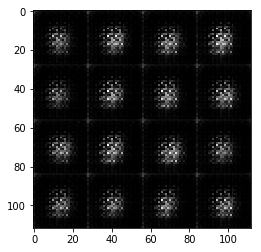

Epoch 0/2 Batch Step 110... Discriminator Loss: 0.2770... Generator Loss: 2.0505
Epoch 0/2 Batch Step 120... Discriminator Loss: 0.1292... Generator Loss: 2.7678
Epoch 0/2 Batch Step 130... Discriminator Loss: 0.1386... Generator Loss: 2.9651
Epoch 0/2 Batch Step 140... Discriminator Loss: 0.2487... Generator Loss: 2.5122
Epoch 0/2 Batch Step 150... Discriminator Loss: 0.0726... Generator Loss: 3.3378
Epoch 0/2 Batch Step 160... Discriminator Loss: 0.0494... Generator Loss: 3.8383
Epoch 0/2 Batch Step 170... Discriminator Loss: 0.0745... Generator Loss: 3.8764
Epoch 0/2 Batch Step 180... Discriminator Loss: 0.1658... Generator Loss: 2.8152
Epoch 0/2 Batch Step 190... Discriminator Loss: 0.0926... Generator Loss: 3.5761
Epoch 0/2 Batch Step 200... Discriminator Loss: 0.6772... Generator Loss: 7.9575


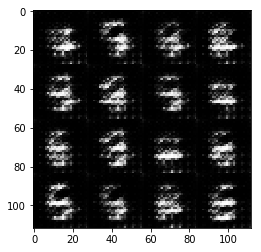

Epoch 0/2 Batch Step 210... Discriminator Loss: 0.4306... Generator Loss: 1.5534
Epoch 0/2 Batch Step 220... Discriminator Loss: 0.3052... Generator Loss: 4.4316
Epoch 0/2 Batch Step 230... Discriminator Loss: 0.1636... Generator Loss: 2.6742
Epoch 0/2 Batch Step 240... Discriminator Loss: 0.1824... Generator Loss: 2.6628
Epoch 0/2 Batch Step 250... Discriminator Loss: 0.1401... Generator Loss: 2.9556
Epoch 0/2 Batch Step 260... Discriminator Loss: 0.1194... Generator Loss: 2.9965
Epoch 0/2 Batch Step 270... Discriminator Loss: 0.0522... Generator Loss: 3.8417
Epoch 0/2 Batch Step 280... Discriminator Loss: 0.1358... Generator Loss: 2.6417
Epoch 0/2 Batch Step 290... Discriminator Loss: 0.0965... Generator Loss: 3.5082
Epoch 0/2 Batch Step 300... Discriminator Loss: 2.6423... Generator Loss: 0.1154


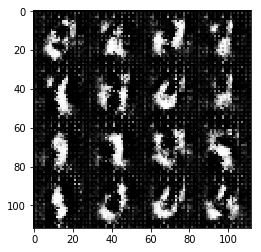

Epoch 0/2 Batch Step 310... Discriminator Loss: 0.1249... Generator Loss: 3.0749
Epoch 0/2 Batch Step 320... Discriminator Loss: 0.0718... Generator Loss: 3.6184
Epoch 0/2 Batch Step 330... Discriminator Loss: 0.0821... Generator Loss: 3.2498
Epoch 0/2 Batch Step 340... Discriminator Loss: 0.0597... Generator Loss: 3.6334
Epoch 0/2 Batch Step 350... Discriminator Loss: 0.0720... Generator Loss: 3.4039
Epoch 0/2 Batch Step 360... Discriminator Loss: 0.0322... Generator Loss: 4.4937
Epoch 0/2 Batch Step 370... Discriminator Loss: 0.0338... Generator Loss: 5.1003
Epoch 0/2 Batch Step 380... Discriminator Loss: 0.0466... Generator Loss: 4.5448
Epoch 0/2 Batch Step 390... Discriminator Loss: 0.6648... Generator Loss: 5.4094
Epoch 0/2 Batch Step 400... Discriminator Loss: 0.0754... Generator Loss: 3.6759


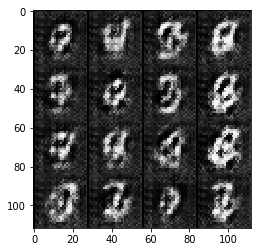

Epoch 0/2 Batch Step 410... Discriminator Loss: 0.0963... Generator Loss: 3.1944
Epoch 0/2 Batch Step 420... Discriminator Loss: 0.0875... Generator Loss: 3.1247
Epoch 0/2 Batch Step 430... Discriminator Loss: 0.3765... Generator Loss: 1.6463
Epoch 0/2 Batch Step 440... Discriminator Loss: 0.1945... Generator Loss: 3.2310
Epoch 0/2 Batch Step 450... Discriminator Loss: 0.1505... Generator Loss: 2.8417
Epoch 0/2 Batch Step 460... Discriminator Loss: 2.5353... Generator Loss: 5.9342
Epoch 0/2 Batch Step 470... Discriminator Loss: 2.8575... Generator Loss: 10.1826
Epoch 0/2 Batch Step 480... Discriminator Loss: 0.1101... Generator Loss: 4.1264
Epoch 0/2 Batch Step 490... Discriminator Loss: 0.3719... Generator Loss: 2.4017
Epoch 0/2 Batch Step 500... Discriminator Loss: 0.1963... Generator Loss: 2.3454


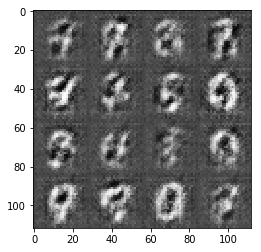

Epoch 0/2 Batch Step 510... Discriminator Loss: 0.1497... Generator Loss: 3.7210
Epoch 0/2 Batch Step 520... Discriminator Loss: 0.5210... Generator Loss: 4.2828
Epoch 0/2 Batch Step 530... Discriminator Loss: 0.1977... Generator Loss: 2.0935
Epoch 0/2 Batch Step 540... Discriminator Loss: 0.2237... Generator Loss: 2.1648
Epoch 0/2 Batch Step 550... Discriminator Loss: 0.2111... Generator Loss: 2.0781
Epoch 0/2 Batch Step 560... Discriminator Loss: 0.3064... Generator Loss: 1.7003
Epoch 0/2 Batch Step 570... Discriminator Loss: 0.2376... Generator Loss: 2.2259
Epoch 0/2 Batch Step 580... Discriminator Loss: 0.7063... Generator Loss: 5.3056
Epoch 0/2 Batch Step 590... Discriminator Loss: 0.6784... Generator Loss: 1.0076
Epoch 0/2 Batch Step 600... Discriminator Loss: 0.2872... Generator Loss: 2.0371


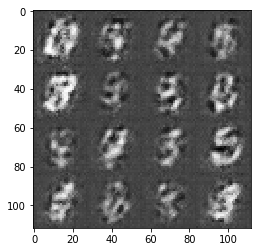

Epoch 0/2 Batch Step 610... Discriminator Loss: 0.1171... Generator Loss: 3.2949
Epoch 0/2 Batch Step 620... Discriminator Loss: 0.1798... Generator Loss: 2.5950
Epoch 0/2 Batch Step 630... Discriminator Loss: 1.7427... Generator Loss: 0.2495
Epoch 0/2 Batch Step 640... Discriminator Loss: 0.2869... Generator Loss: 2.0872
Epoch 0/2 Batch Step 650... Discriminator Loss: 0.3371... Generator Loss: 1.6507
Epoch 0/2 Batch Step 660... Discriminator Loss: 0.2754... Generator Loss: 1.8637
Epoch 0/2 Batch Step 670... Discriminator Loss: 0.2478... Generator Loss: 2.1413
Epoch 0/2 Batch Step 680... Discriminator Loss: 0.1862... Generator Loss: 2.2045
Epoch 0/2 Batch Step 690... Discriminator Loss: 0.2810... Generator Loss: 1.8385
Epoch 0/2 Batch Step 700... Discriminator Loss: 0.6590... Generator Loss: 1.0850


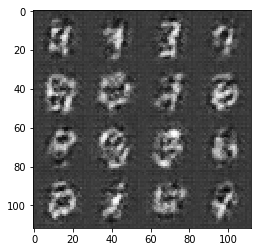

Epoch 0/2 Batch Step 710... Discriminator Loss: 0.2751... Generator Loss: 1.8349
Epoch 0/2 Batch Step 720... Discriminator Loss: 0.1189... Generator Loss: 2.9512
Epoch 0/2 Batch Step 730... Discriminator Loss: 0.2200... Generator Loss: 2.0895
Epoch 0/2 Batch Step 740... Discriminator Loss: 0.2211... Generator Loss: 2.0590
Epoch 0/2 Batch Step 750... Discriminator Loss: 0.2010... Generator Loss: 2.3180
Epoch 0/2 Batch Step 760... Discriminator Loss: 0.1882... Generator Loss: 2.4545
Epoch 0/2 Batch Step 770... Discriminator Loss: 0.2379... Generator Loss: 2.5808
Epoch 0/2 Batch Step 780... Discriminator Loss: 2.1560... Generator Loss: 0.1826
Epoch 0/2 Batch Step 790... Discriminator Loss: 0.2298... Generator Loss: 2.1484
Epoch 0/2 Batch Step 800... Discriminator Loss: 0.2794... Generator Loss: 1.8053


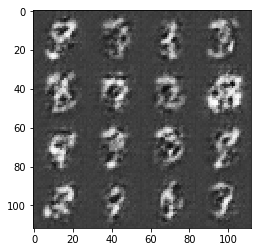

Epoch 0/2 Batch Step 810... Discriminator Loss: 0.1629... Generator Loss: 2.2694
Epoch 0/2 Batch Step 820... Discriminator Loss: 0.1552... Generator Loss: 2.3230
Epoch 0/2 Batch Step 830... Discriminator Loss: 0.1329... Generator Loss: 2.7097
Epoch 0/2 Batch Step 840... Discriminator Loss: 0.1336... Generator Loss: 2.7402
Epoch 0/2 Batch Step 850... Discriminator Loss: 0.1151... Generator Loss: 2.7987
Epoch 0/2 Batch Step 860... Discriminator Loss: 0.1431... Generator Loss: 2.4126
Epoch 0/2 Batch Step 870... Discriminator Loss: 0.1163... Generator Loss: 2.6284
Epoch 0/2 Batch Step 880... Discriminator Loss: 0.0820... Generator Loss: 3.1408
Epoch 0/2 Batch Step 890... Discriminator Loss: 0.1884... Generator Loss: 3.9839
Epoch 0/2 Batch Step 900... Discriminator Loss: 0.1281... Generator Loss: 2.7431


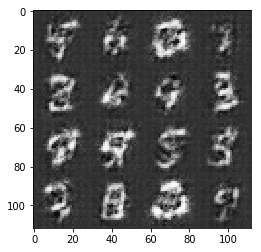

Epoch 0/2 Batch Step 910... Discriminator Loss: 0.1330... Generator Loss: 2.7692
Epoch 0/2 Batch Step 920... Discriminator Loss: 0.2940... Generator Loss: 5.6217
Epoch 0/2 Batch Step 930... Discriminator Loss: 0.1989... Generator Loss: 4.6635
Epoch 1/2 Batch Step 940... Discriminator Loss: 0.3224... Generator Loss: 1.8289
Epoch 1/2 Batch Step 950... Discriminator Loss: 0.2444... Generator Loss: 1.9703
Epoch 1/2 Batch Step 960... Discriminator Loss: 0.2631... Generator Loss: 1.8737
Epoch 1/2 Batch Step 970... Discriminator Loss: 0.1637... Generator Loss: 2.4757
Epoch 1/2 Batch Step 980... Discriminator Loss: 0.1690... Generator Loss: 2.1263
Epoch 1/2 Batch Step 990... Discriminator Loss: 0.1188... Generator Loss: 2.6300
Epoch 1/2 Batch Step 1000... Discriminator Loss: 0.1568... Generator Loss: 2.5166


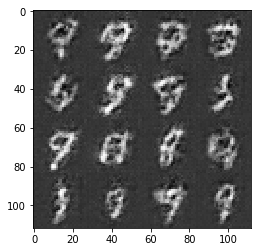

Epoch 1/2 Batch Step 1010... Discriminator Loss: 0.1756... Generator Loss: 2.2579
Epoch 1/2 Batch Step 1020... Discriminator Loss: 0.0744... Generator Loss: 3.2372
Epoch 1/2 Batch Step 1030... Discriminator Loss: 0.1864... Generator Loss: 2.2519
Epoch 1/2 Batch Step 1040... Discriminator Loss: 0.1334... Generator Loss: 2.5292
Epoch 1/2 Batch Step 1050... Discriminator Loss: 0.1316... Generator Loss: 2.6523
Epoch 1/2 Batch Step 1060... Discriminator Loss: 0.1035... Generator Loss: 2.9111
Epoch 1/2 Batch Step 1070... Discriminator Loss: 0.0803... Generator Loss: 3.1043
Epoch 1/2 Batch Step 1080... Discriminator Loss: 0.1174... Generator Loss: 2.6775
Epoch 1/2 Batch Step 1090... Discriminator Loss: 0.0654... Generator Loss: 3.3591
Epoch 1/2 Batch Step 1100... Discriminator Loss: 5.3205... Generator Loss: 0.0074


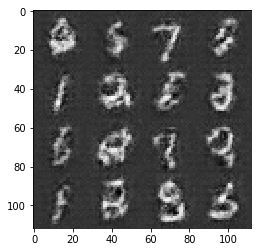

Epoch 1/2 Batch Step 1110... Discriminator Loss: 0.4233... Generator Loss: 2.7010
Epoch 1/2 Batch Step 1120... Discriminator Loss: 0.3068... Generator Loss: 1.7532
Epoch 1/2 Batch Step 1130... Discriminator Loss: 0.3230... Generator Loss: 1.6112
Epoch 1/2 Batch Step 1140... Discriminator Loss: 0.1506... Generator Loss: 2.5769
Epoch 1/2 Batch Step 1150... Discriminator Loss: 0.2300... Generator Loss: 2.1029
Epoch 1/2 Batch Step 1160... Discriminator Loss: 0.1709... Generator Loss: 2.4232
Epoch 1/2 Batch Step 1170... Discriminator Loss: 0.1437... Generator Loss: 2.3336
Epoch 1/2 Batch Step 1180... Discriminator Loss: 0.0902... Generator Loss: 2.9970
Epoch 1/2 Batch Step 1190... Discriminator Loss: 0.0979... Generator Loss: 3.1057
Epoch 1/2 Batch Step 1200... Discriminator Loss: 0.2346... Generator Loss: 1.8904


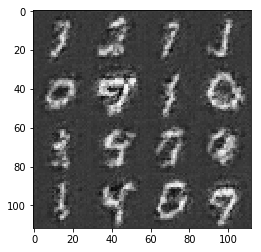

Epoch 1/2 Batch Step 1210... Discriminator Loss: 0.0567... Generator Loss: 3.7120
Epoch 1/2 Batch Step 1220... Discriminator Loss: 0.4477... Generator Loss: 1.2317
Epoch 1/2 Batch Step 1230... Discriminator Loss: 0.1411... Generator Loss: 2.4734
Epoch 1/2 Batch Step 1240... Discriminator Loss: 0.1483... Generator Loss: 2.5397
Epoch 1/2 Batch Step 1250... Discriminator Loss: 0.0970... Generator Loss: 3.2297
Epoch 1/2 Batch Step 1260... Discriminator Loss: 0.0751... Generator Loss: 3.4149
Epoch 1/2 Batch Step 1270... Discriminator Loss: 0.0528... Generator Loss: 4.3203
Epoch 1/2 Batch Step 1280... Discriminator Loss: 0.0812... Generator Loss: 3.3064
Epoch 1/2 Batch Step 1290... Discriminator Loss: 0.1132... Generator Loss: 2.6346
Epoch 1/2 Batch Step 1300... Discriminator Loss: 0.1176... Generator Loss: 2.5400


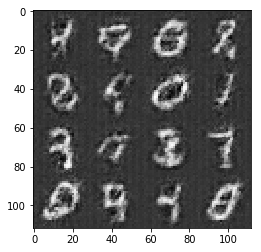

Epoch 1/2 Batch Step 1310... Discriminator Loss: 0.1545... Generator Loss: 2.5829
Epoch 1/2 Batch Step 1320... Discriminator Loss: 0.1061... Generator Loss: 2.9061
Epoch 1/2 Batch Step 1330... Discriminator Loss: 6.1923... Generator Loss: 6.3452
Epoch 1/2 Batch Step 1340... Discriminator Loss: 0.6665... Generator Loss: 1.3351
Epoch 1/2 Batch Step 1350... Discriminator Loss: 0.3821... Generator Loss: 2.0605
Epoch 1/2 Batch Step 1360... Discriminator Loss: 0.3215... Generator Loss: 1.8672
Epoch 1/2 Batch Step 1370... Discriminator Loss: 0.3100... Generator Loss: 1.7786
Epoch 1/2 Batch Step 1380... Discriminator Loss: 0.2410... Generator Loss: 2.0775
Epoch 1/2 Batch Step 1390... Discriminator Loss: 0.2288... Generator Loss: 2.0798
Epoch 1/2 Batch Step 1400... Discriminator Loss: 0.2419... Generator Loss: 1.9474


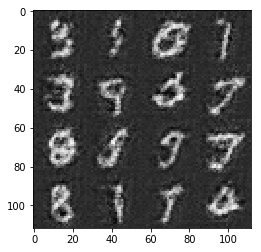

Epoch 1/2 Batch Step 1410... Discriminator Loss: 0.0650... Generator Loss: 3.6683
Epoch 1/2 Batch Step 1420... Discriminator Loss: 0.1027... Generator Loss: 3.0965
Epoch 1/2 Batch Step 1430... Discriminator Loss: 0.1278... Generator Loss: 2.6624
Epoch 1/2 Batch Step 1440... Discriminator Loss: 0.0632... Generator Loss: 3.8558
Epoch 1/2 Batch Step 1450... Discriminator Loss: 0.0411... Generator Loss: 4.0109
Epoch 1/2 Batch Step 1460... Discriminator Loss: 0.0902... Generator Loss: 2.9938
Epoch 1/2 Batch Step 1470... Discriminator Loss: 0.1664... Generator Loss: 2.3153
Epoch 1/2 Batch Step 1480... Discriminator Loss: 0.0893... Generator Loss: 3.1881
Epoch 1/2 Batch Step 1490... Discriminator Loss: 0.2163... Generator Loss: 2.0508
Epoch 1/2 Batch Step 1500... Discriminator Loss: 0.1040... Generator Loss: 2.9291


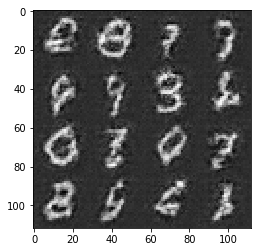

Epoch 1/2 Batch Step 1510... Discriminator Loss: 0.0989... Generator Loss: 2.8791
Epoch 1/2 Batch Step 1520... Discriminator Loss: 0.4128... Generator Loss: 1.2843
Epoch 1/2 Batch Step 1530... Discriminator Loss: 5.7392... Generator Loss: 0.0229
Epoch 1/2 Batch Step 1540... Discriminator Loss: 0.3242... Generator Loss: 1.7677
Epoch 1/2 Batch Step 1550... Discriminator Loss: 0.3913... Generator Loss: 1.5022
Epoch 1/2 Batch Step 1560... Discriminator Loss: 0.2184... Generator Loss: 2.2235
Epoch 1/2 Batch Step 1570... Discriminator Loss: 0.1554... Generator Loss: 2.7852
Epoch 1/2 Batch Step 1580... Discriminator Loss: 0.2105... Generator Loss: 2.1360
Epoch 1/2 Batch Step 1590... Discriminator Loss: 0.1923... Generator Loss: 2.0611
Epoch 1/2 Batch Step 1600... Discriminator Loss: 0.0733... Generator Loss: 3.4013


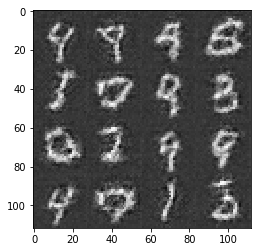

Epoch 1/2 Batch Step 1610... Discriminator Loss: 0.2836... Generator Loss: 1.6594
Epoch 1/2 Batch Step 1620... Discriminator Loss: 0.1105... Generator Loss: 2.8213
Epoch 1/2 Batch Step 1630... Discriminator Loss: 0.0668... Generator Loss: 3.7631
Epoch 1/2 Batch Step 1640... Discriminator Loss: 0.0788... Generator Loss: 3.3323
Epoch 1/2 Batch Step 1650... Discriminator Loss: 0.2394... Generator Loss: 1.8166
Epoch 1/2 Batch Step 1660... Discriminator Loss: 0.0704... Generator Loss: 4.0326
Epoch 1/2 Batch Step 1670... Discriminator Loss: 0.0981... Generator Loss: 2.7627
Epoch 1/2 Batch Step 1680... Discriminator Loss: 0.0935... Generator Loss: 2.9814
Epoch 1/2 Batch Step 1690... Discriminator Loss: 0.0632... Generator Loss: 3.4678
Epoch 1/2 Batch Step 1700... Discriminator Loss: 0.0516... Generator Loss: 3.8125


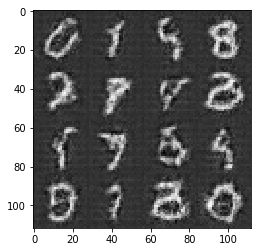

Epoch 1/2 Batch Step 1710... Discriminator Loss: 0.0559... Generator Loss: 3.4590
Epoch 1/2 Batch Step 1720... Discriminator Loss: 0.0558... Generator Loss: 3.6490
Epoch 1/2 Batch Step 1730... Discriminator Loss: 0.0642... Generator Loss: 3.4830
Epoch 1/2 Batch Step 1740... Discriminator Loss: 0.0450... Generator Loss: 3.7997
Epoch 1/2 Batch Step 1750... Discriminator Loss: 0.0224... Generator Loss: 5.0064
Epoch 1/2 Batch Step 1760... Discriminator Loss: 0.0871... Generator Loss: 2.8986
Epoch 1/2 Batch Step 1770... Discriminator Loss: 0.1432... Generator Loss: 3.4649
Epoch 1/2 Batch Step 1780... Discriminator Loss: 0.0757... Generator Loss: 3.2658
Epoch 1/2 Batch Step 1790... Discriminator Loss: 0.0396... Generator Loss: 3.9960
Epoch 1/2 Batch Step 1800... Discriminator Loss: 0.0359... Generator Loss: 3.8682


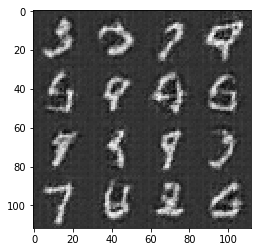

Epoch 1/2 Batch Step 1810... Discriminator Loss: 0.0500... Generator Loss: 3.5430
Epoch 1/2 Batch Step 1820... Discriminator Loss: 0.1227... Generator Loss: 2.5230
Epoch 1/2 Batch Step 1830... Discriminator Loss: 0.4101... Generator Loss: 4.0717
Epoch 1/2 Batch Step 1840... Discriminator Loss: 1.2121... Generator Loss: 0.6221
Epoch 1/2 Batch Step 1850... Discriminator Loss: 1.1863... Generator Loss: 2.8531
Epoch 1/2 Batch Step 1860... Discriminator Loss: 0.8247... Generator Loss: 4.1508
Epoch 1/2 Batch Step 1870... Discriminator Loss: 0.2253... Generator Loss: 2.9087
Done Training!


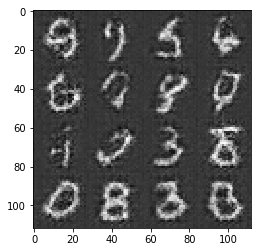

In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1 Batch Step 10... Discriminator Loss: 0.6708... Generator Loss: 1.2309
Epoch 0/1 Batch Step 20... Discriminator Loss: 0.2444... Generator Loss: 4.6075
Epoch 0/1 Batch Step 30... Discriminator Loss: 0.1326... Generator Loss: 4.6308
Epoch 0/1 Batch Step 40... Discriminator Loss: 0.0538... Generator Loss: 3.9196
Epoch 0/1 Batch Step 50... Discriminator Loss: 0.1260... Generator Loss: 3.4357
Epoch 0/1 Batch Step 60... Discriminator Loss: 0.0913... Generator Loss: 4.9214
Epoch 0/1 Batch Step 70... Discriminator Loss: 1.0735... Generator Loss: 10.2355
Epoch 0/1 Batch Step 80... Discriminator Loss: 0.4340... Generator Loss: 11.3105
Epoch 0/1 Batch Step 90... Discriminator Loss: 1.6543... Generator Loss: 0.3102
Epoch 0/1 Batch Step 100... Discriminator Loss: 0.2194... Generator Loss: 2.2513


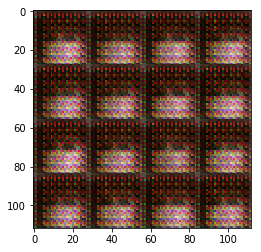

Epoch 0/1 Batch Step 110... Discriminator Loss: 0.1811... Generator Loss: 2.3317
Epoch 0/1 Batch Step 120... Discriminator Loss: 0.1823... Generator Loss: 2.6538
Epoch 0/1 Batch Step 130... Discriminator Loss: 0.1678... Generator Loss: 2.4620
Epoch 0/1 Batch Step 140... Discriminator Loss: 0.2267... Generator Loss: 2.4310
Epoch 0/1 Batch Step 150... Discriminator Loss: 0.1514... Generator Loss: 3.0492
Epoch 0/1 Batch Step 160... Discriminator Loss: 0.1448... Generator Loss: 2.6180
Epoch 0/1 Batch Step 170... Discriminator Loss: 0.1274... Generator Loss: 2.9059
Epoch 0/1 Batch Step 180... Discriminator Loss: 0.0917... Generator Loss: 3.2866
Epoch 0/1 Batch Step 190... Discriminator Loss: 0.0971... Generator Loss: 2.9518
Epoch 0/1 Batch Step 200... Discriminator Loss: 0.0655... Generator Loss: 3.2779


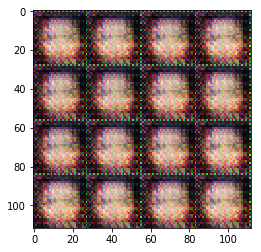

Epoch 0/1 Batch Step 210... Discriminator Loss: 0.1150... Generator Loss: 2.6369
Epoch 0/1 Batch Step 220... Discriminator Loss: 0.0464... Generator Loss: 4.6381
Epoch 0/1 Batch Step 230... Discriminator Loss: 0.0828... Generator Loss: 3.0427
Epoch 0/1 Batch Step 240... Discriminator Loss: 0.0786... Generator Loss: 3.6251
Epoch 0/1 Batch Step 250... Discriminator Loss: 0.0557... Generator Loss: 3.9651
Epoch 0/1 Batch Step 260... Discriminator Loss: 0.1318... Generator Loss: 7.4674
Epoch 0/1 Batch Step 270... Discriminator Loss: 0.0868... Generator Loss: 2.6085
Epoch 0/1 Batch Step 280... Discriminator Loss: 0.0681... Generator Loss: 6.7890
Epoch 0/1 Batch Step 290... Discriminator Loss: 0.1908... Generator Loss: 7.2511
Epoch 0/1 Batch Step 300... Discriminator Loss: 0.0267... Generator Loss: 4.8675


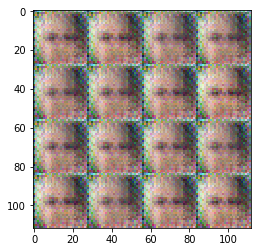

Epoch 0/1 Batch Step 310... Discriminator Loss: 1.7338... Generator Loss: 10.8679
Epoch 0/1 Batch Step 320... Discriminator Loss: 1.8575... Generator Loss: 0.2377
Epoch 0/1 Batch Step 330... Discriminator Loss: 0.9874... Generator Loss: 1.0379
Epoch 0/1 Batch Step 340... Discriminator Loss: 1.3802... Generator Loss: 0.8291
Epoch 0/1 Batch Step 350... Discriminator Loss: 1.4316... Generator Loss: 1.0135
Epoch 0/1 Batch Step 360... Discriminator Loss: 1.2548... Generator Loss: 0.7878
Epoch 0/1 Batch Step 370... Discriminator Loss: 0.7857... Generator Loss: 1.2017
Epoch 0/1 Batch Step 380... Discriminator Loss: 1.4886... Generator Loss: 1.0508
Epoch 0/1 Batch Step 390... Discriminator Loss: 0.6530... Generator Loss: 1.3325
Epoch 0/1 Batch Step 400... Discriminator Loss: 0.5842... Generator Loss: 1.7107


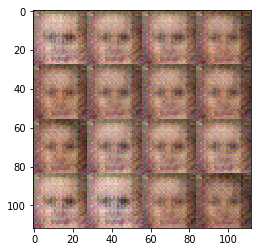

Epoch 0/1 Batch Step 410... Discriminator Loss: 0.9197... Generator Loss: 0.8837
Epoch 0/1 Batch Step 420... Discriminator Loss: 0.6774... Generator Loss: 2.5190
Epoch 0/1 Batch Step 430... Discriminator Loss: 0.6022... Generator Loss: 1.5432
Epoch 0/1 Batch Step 440... Discriminator Loss: 0.4711... Generator Loss: 1.9369
Epoch 0/1 Batch Step 450... Discriminator Loss: 0.2462... Generator Loss: 2.6476
Epoch 0/1 Batch Step 460... Discriminator Loss: 0.3295... Generator Loss: 1.9581
Epoch 0/1 Batch Step 470... Discriminator Loss: 0.6327... Generator Loss: 1.5867
Epoch 0/1 Batch Step 480... Discriminator Loss: 0.3344... Generator Loss: 1.9494
Epoch 0/1 Batch Step 490... Discriminator Loss: 0.7083... Generator Loss: 1.3109
Epoch 0/1 Batch Step 500... Discriminator Loss: 0.5809... Generator Loss: 2.4786


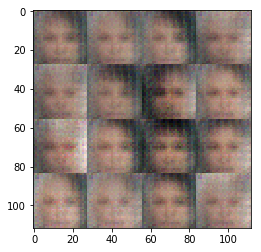

Epoch 0/1 Batch Step 510... Discriminator Loss: 0.3299... Generator Loss: 2.7896
Epoch 0/1 Batch Step 520... Discriminator Loss: 0.6008... Generator Loss: 1.5870
Epoch 0/1 Batch Step 530... Discriminator Loss: 0.5401... Generator Loss: 1.8026
Epoch 0/1 Batch Step 540... Discriminator Loss: 1.1845... Generator Loss: 2.6441
Epoch 0/1 Batch Step 550... Discriminator Loss: 0.2786... Generator Loss: 2.2902
Epoch 0/1 Batch Step 560... Discriminator Loss: 1.5165... Generator Loss: 0.3827
Epoch 0/1 Batch Step 570... Discriminator Loss: 0.7466... Generator Loss: 3.5448
Epoch 0/1 Batch Step 580... Discriminator Loss: 0.3964... Generator Loss: 2.0836
Epoch 0/1 Batch Step 590... Discriminator Loss: 0.6814... Generator Loss: 0.8557
Epoch 0/1 Batch Step 600... Discriminator Loss: 1.6299... Generator Loss: 0.3441


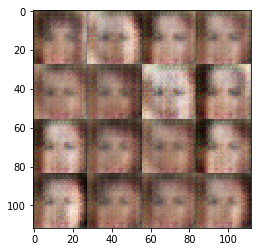

Epoch 0/1 Batch Step 610... Discriminator Loss: 0.3770... Generator Loss: 1.6282
Epoch 0/1 Batch Step 620... Discriminator Loss: 0.2584... Generator Loss: 2.5125
Epoch 0/1 Batch Step 630... Discriminator Loss: 0.2356... Generator Loss: 2.2845
Epoch 0/1 Batch Step 640... Discriminator Loss: 0.5548... Generator Loss: 1.1194
Epoch 0/1 Batch Step 650... Discriminator Loss: 0.1134... Generator Loss: 3.1866
Epoch 0/1 Batch Step 660... Discriminator Loss: 2.4306... Generator Loss: 0.1405
Epoch 0/1 Batch Step 670... Discriminator Loss: 0.3837... Generator Loss: 3.5762
Epoch 0/1 Batch Step 680... Discriminator Loss: 0.1833... Generator Loss: 2.3698
Epoch 0/1 Batch Step 690... Discriminator Loss: 0.1335... Generator Loss: 2.5437
Epoch 0/1 Batch Step 700... Discriminator Loss: 0.2959... Generator Loss: 1.7407


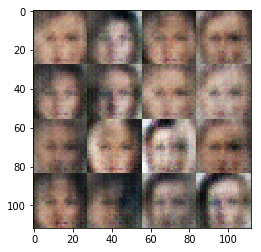

Epoch 0/1 Batch Step 710... Discriminator Loss: 0.1639... Generator Loss: 7.6591
Epoch 0/1 Batch Step 720... Discriminator Loss: 1.6641... Generator Loss: 0.2600
Epoch 0/1 Batch Step 730... Discriminator Loss: 0.0361... Generator Loss: 5.0843
Epoch 0/1 Batch Step 740... Discriminator Loss: 0.1689... Generator Loss: 3.3113
Epoch 0/1 Batch Step 750... Discriminator Loss: 0.0823... Generator Loss: 4.1478
Epoch 0/1 Batch Step 760... Discriminator Loss: 0.0321... Generator Loss: 6.2339
Epoch 0/1 Batch Step 770... Discriminator Loss: 0.0479... Generator Loss: 3.9575
Epoch 0/1 Batch Step 780... Discriminator Loss: 0.5057... Generator Loss: 1.3191
Epoch 0/1 Batch Step 790... Discriminator Loss: 0.2461... Generator Loss: 10.7848
Epoch 0/1 Batch Step 800... Discriminator Loss: 0.0851... Generator Loss: 3.5288


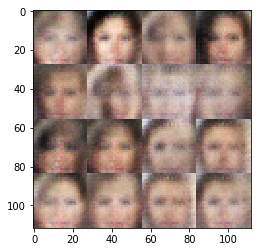

Epoch 0/1 Batch Step 810... Discriminator Loss: 0.2125... Generator Loss: 2.4410
Epoch 0/1 Batch Step 820... Discriminator Loss: 0.2495... Generator Loss: 1.7874
Epoch 0/1 Batch Step 830... Discriminator Loss: 0.7082... Generator Loss: 0.8624
Epoch 0/1 Batch Step 840... Discriminator Loss: 0.5382... Generator Loss: 11.0638
Epoch 0/1 Batch Step 850... Discriminator Loss: 0.3713... Generator Loss: 1.4277
Epoch 0/1 Batch Step 860... Discriminator Loss: 0.0837... Generator Loss: 7.9197
Epoch 0/1 Batch Step 870... Discriminator Loss: 0.4488... Generator Loss: 1.3272
Epoch 0/1 Batch Step 880... Discriminator Loss: 0.0584... Generator Loss: 4.0833
Epoch 0/1 Batch Step 890... Discriminator Loss: 0.1461... Generator Loss: 3.3060
Epoch 0/1 Batch Step 900... Discriminator Loss: 0.4066... Generator Loss: 1.3565


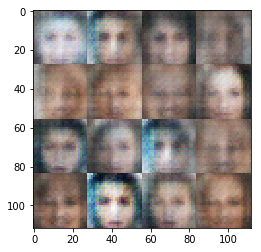

Epoch 0/1 Batch Step 910... Discriminator Loss: 0.3210... Generator Loss: 1.5618
Epoch 0/1 Batch Step 920... Discriminator Loss: 0.0928... Generator Loss: 3.1479
Epoch 0/1 Batch Step 930... Discriminator Loss: 0.0297... Generator Loss: 5.2141
Epoch 0/1 Batch Step 940... Discriminator Loss: 0.9759... Generator Loss: 0.5849
Epoch 0/1 Batch Step 950... Discriminator Loss: 1.3911... Generator Loss: 0.3729
Epoch 0/1 Batch Step 960... Discriminator Loss: 0.2475... Generator Loss: 2.4390
Epoch 0/1 Batch Step 970... Discriminator Loss: 0.1080... Generator Loss: 8.5454
Epoch 0/1 Batch Step 980... Discriminator Loss: 0.0765... Generator Loss: 3.7574
Epoch 0/1 Batch Step 990... Discriminator Loss: 0.2122... Generator Loss: 2.1335
Epoch 0/1 Batch Step 1000... Discriminator Loss: 0.0820... Generator Loss: 3.5455


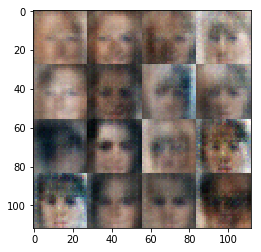

Epoch 0/1 Batch Step 1010... Discriminator Loss: 1.9385... Generator Loss: 9.9605
Epoch 0/1 Batch Step 1020... Discriminator Loss: 0.0459... Generator Loss: 6.4227
Epoch 0/1 Batch Step 1030... Discriminator Loss: 0.0383... Generator Loss: 7.5012
Epoch 0/1 Batch Step 1040... Discriminator Loss: 0.0187... Generator Loss: 6.2187
Epoch 0/1 Batch Step 1050... Discriminator Loss: 0.4454... Generator Loss: 1.2025
Epoch 0/1 Batch Step 1060... Discriminator Loss: 0.1952... Generator Loss: 2.1681
Epoch 0/1 Batch Step 1070... Discriminator Loss: 0.0328... Generator Loss: 8.8650
Epoch 0/1 Batch Step 1080... Discriminator Loss: 0.0125... Generator Loss: 8.9507
Epoch 0/1 Batch Step 1090... Discriminator Loss: 0.0534... Generator Loss: 3.7305
Epoch 0/1 Batch Step 1100... Discriminator Loss: 0.0200... Generator Loss: 11.9468


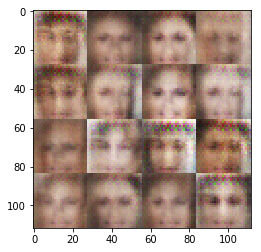

Epoch 0/1 Batch Step 1110... Discriminator Loss: 0.0321... Generator Loss: 6.9249
Epoch 0/1 Batch Step 1120... Discriminator Loss: 0.0941... Generator Loss: 3.5175
Epoch 0/1 Batch Step 1130... Discriminator Loss: 0.0108... Generator Loss: 8.1744
Epoch 0/1 Batch Step 1140... Discriminator Loss: 0.2814... Generator Loss: 7.5639
Epoch 0/1 Batch Step 1150... Discriminator Loss: 0.0427... Generator Loss: 7.1932
Epoch 0/1 Batch Step 1160... Discriminator Loss: 0.0558... Generator Loss: 5.8443
Epoch 0/1 Batch Step 1170... Discriminator Loss: 2.0222... Generator Loss: 0.1768
Epoch 0/1 Batch Step 1180... Discriminator Loss: 0.0784... Generator Loss: 3.8431
Epoch 0/1 Batch Step 1190... Discriminator Loss: 0.2058... Generator Loss: 12.0750
Epoch 0/1 Batch Step 1200... Discriminator Loss: 0.0266... Generator Loss: 9.2191


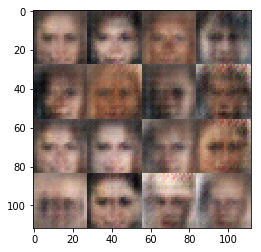

Epoch 0/1 Batch Step 1210... Discriminator Loss: 0.0084... Generator Loss: 7.8331
Epoch 0/1 Batch Step 1220... Discriminator Loss: 0.0534... Generator Loss: 3.6958
Epoch 0/1 Batch Step 1230... Discriminator Loss: 2.1453... Generator Loss: 0.1658
Epoch 0/1 Batch Step 1240... Discriminator Loss: 0.0053... Generator Loss: 8.7028
Epoch 0/1 Batch Step 1250... Discriminator Loss: 0.0849... Generator Loss: 4.5485
Epoch 0/1 Batch Step 1260... Discriminator Loss: 0.7868... Generator Loss: 0.7690
Epoch 0/1 Batch Step 1270... Discriminator Loss: 0.9839... Generator Loss: 0.5548
Epoch 0/1 Batch Step 1280... Discriminator Loss: 0.0548... Generator Loss: 3.7126
Epoch 0/1 Batch Step 1290... Discriminator Loss: 0.0168... Generator Loss: 5.3431
Epoch 0/1 Batch Step 1300... Discriminator Loss: 0.1314... Generator Loss: 9.5746


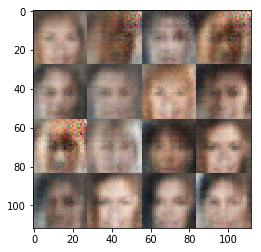

Epoch 0/1 Batch Step 1310... Discriminator Loss: 0.0064... Generator Loss: 8.4113
Epoch 0/1 Batch Step 1320... Discriminator Loss: 0.0293... Generator Loss: 4.6373
Epoch 0/1 Batch Step 1330... Discriminator Loss: 0.0131... Generator Loss: 6.1654
Epoch 0/1 Batch Step 1340... Discriminator Loss: 0.0313... Generator Loss: 5.9916
Epoch 0/1 Batch Step 1350... Discriminator Loss: 0.1632... Generator Loss: 2.3549
Epoch 0/1 Batch Step 1360... Discriminator Loss: 0.0556... Generator Loss: 4.5515
Epoch 0/1 Batch Step 1370... Discriminator Loss: 0.0396... Generator Loss: 6.2128
Epoch 0/1 Batch Step 1380... Discriminator Loss: 0.1644... Generator Loss: 7.1106
Epoch 0/1 Batch Step 1390... Discriminator Loss: 0.8604... Generator Loss: 0.7099
Epoch 0/1 Batch Step 1400... Discriminator Loss: 0.1752... Generator Loss: 7.4496


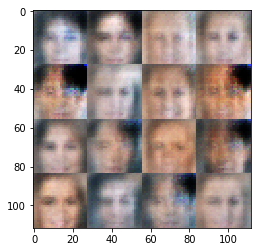

Epoch 0/1 Batch Step 1410... Discriminator Loss: 0.0684... Generator Loss: 6.8084
Epoch 0/1 Batch Step 1420... Discriminator Loss: 0.1517... Generator Loss: 2.6642
Epoch 0/1 Batch Step 1430... Discriminator Loss: 0.0204... Generator Loss: 5.2243
Epoch 0/1 Batch Step 1440... Discriminator Loss: 0.1751... Generator Loss: 2.0573
Epoch 0/1 Batch Step 1450... Discriminator Loss: 0.0472... Generator Loss: 6.3973
Epoch 0/1 Batch Step 1460... Discriminator Loss: 0.8016... Generator Loss: 6.5276
Epoch 0/1 Batch Step 1470... Discriminator Loss: 0.0232... Generator Loss: 7.0128
Epoch 0/1 Batch Step 1480... Discriminator Loss: 0.4754... Generator Loss: 1.4646
Epoch 0/1 Batch Step 1490... Discriminator Loss: 0.5574... Generator Loss: 7.5099
Epoch 0/1 Batch Step 1500... Discriminator Loss: 0.2249... Generator Loss: 3.1531


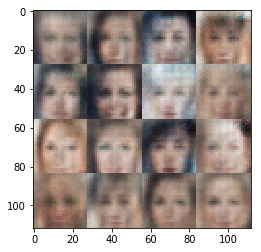

Epoch 0/1 Batch Step 1510... Discriminator Loss: 0.0507... Generator Loss: 4.1687
Epoch 0/1 Batch Step 1520... Discriminator Loss: 0.0293... Generator Loss: 7.0795
Epoch 0/1 Batch Step 1530... Discriminator Loss: 0.0288... Generator Loss: 4.8553
Epoch 0/1 Batch Step 1540... Discriminator Loss: 0.0169... Generator Loss: 7.2879
Epoch 0/1 Batch Step 1550... Discriminator Loss: 0.0269... Generator Loss: 5.6416
Epoch 0/1 Batch Step 1560... Discriminator Loss: 0.0227... Generator Loss: 4.5567
Epoch 0/1 Batch Step 1570... Discriminator Loss: 0.0412... Generator Loss: 4.4071
Epoch 0/1 Batch Step 1580... Discriminator Loss: 1.4425... Generator Loss: 11.7225
Epoch 0/1 Batch Step 1590... Discriminator Loss: 0.0210... Generator Loss: 7.6620
Epoch 0/1 Batch Step 1600... Discriminator Loss: 0.0069... Generator Loss: 8.2679


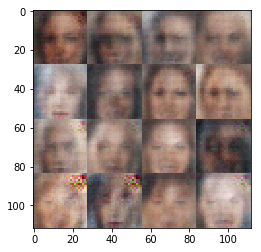

Epoch 0/1 Batch Step 1610... Discriminator Loss: 0.0163... Generator Loss: 5.1398
Epoch 0/1 Batch Step 1620... Discriminator Loss: 0.0177... Generator Loss: 5.9217
Epoch 0/1 Batch Step 1630... Discriminator Loss: 0.0125... Generator Loss: 7.1886
Epoch 0/1 Batch Step 1640... Discriminator Loss: 0.2044... Generator Loss: 2.0845
Epoch 0/1 Batch Step 1650... Discriminator Loss: 0.0080... Generator Loss: 7.3590
Epoch 0/1 Batch Step 1660... Discriminator Loss: 0.0223... Generator Loss: 7.6946
Epoch 0/1 Batch Step 1670... Discriminator Loss: 0.0203... Generator Loss: 11.8516
Epoch 0/1 Batch Step 1680... Discriminator Loss: 0.0259... Generator Loss: 4.6370
Epoch 0/1 Batch Step 1690... Discriminator Loss: 0.0145... Generator Loss: 9.2334
Epoch 0/1 Batch Step 1700... Discriminator Loss: 0.1743... Generator Loss: 2.0955


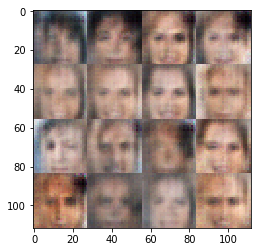

Epoch 0/1 Batch Step 1710... Discriminator Loss: 0.4686... Generator Loss: 7.1363
Epoch 0/1 Batch Step 1720... Discriminator Loss: 0.0711... Generator Loss: 3.8556
Epoch 0/1 Batch Step 1730... Discriminator Loss: 0.0874... Generator Loss: 9.2293
Epoch 0/1 Batch Step 1740... Discriminator Loss: 0.0442... Generator Loss: 3.7298
Epoch 0/1 Batch Step 1750... Discriminator Loss: 0.0147... Generator Loss: 7.0001
Epoch 0/1 Batch Step 1760... Discriminator Loss: 0.1264... Generator Loss: 3.0143
Epoch 0/1 Batch Step 1770... Discriminator Loss: 0.1161... Generator Loss: 3.4263
Epoch 0/1 Batch Step 1780... Discriminator Loss: 0.0724... Generator Loss: 3.0835
Epoch 0/1 Batch Step 1790... Discriminator Loss: 0.3411... Generator Loss: 1.5929
Epoch 0/1 Batch Step 1800... Discriminator Loss: 0.0568... Generator Loss: 8.8900


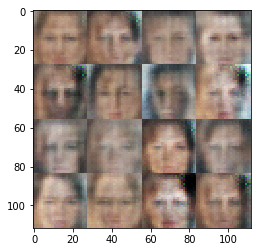

Epoch 0/1 Batch Step 1810... Discriminator Loss: 0.0521... Generator Loss: 3.6457
Epoch 0/1 Batch Step 1820... Discriminator Loss: 0.8537... Generator Loss: 5.4831
Epoch 0/1 Batch Step 1830... Discriminator Loss: 0.1211... Generator Loss: 3.6633
Epoch 0/1 Batch Step 1840... Discriminator Loss: 0.0281... Generator Loss: 9.3211
Epoch 0/1 Batch Step 1850... Discriminator Loss: 0.0787... Generator Loss: 3.6994
Epoch 0/1 Batch Step 1860... Discriminator Loss: 0.1752... Generator Loss: 2.1804
Epoch 0/1 Batch Step 1870... Discriminator Loss: 0.2654... Generator Loss: 1.6952
Epoch 0/1 Batch Step 1880... Discriminator Loss: 0.0448... Generator Loss: 4.5745
Epoch 0/1 Batch Step 1890... Discriminator Loss: 0.1095... Generator Loss: 2.7933
Epoch 0/1 Batch Step 1900... Discriminator Loss: 0.9496... Generator Loss: 0.6551


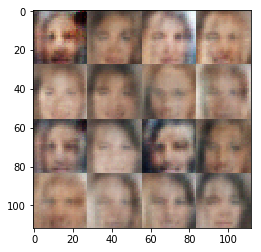

Epoch 0/1 Batch Step 1910... Discriminator Loss: 0.0324... Generator Loss: 4.8175
Epoch 0/1 Batch Step 1920... Discriminator Loss: 0.0142... Generator Loss: 7.4784
Epoch 0/1 Batch Step 1930... Discriminator Loss: 1.0296... Generator Loss: 0.6186
Epoch 0/1 Batch Step 1940... Discriminator Loss: 0.1835... Generator Loss: 2.2891
Epoch 0/1 Batch Step 1950... Discriminator Loss: 0.0389... Generator Loss: 3.9507
Epoch 0/1 Batch Step 1960... Discriminator Loss: 0.0665... Generator Loss: 3.6531
Epoch 0/1 Batch Step 1970... Discriminator Loss: 0.0299... Generator Loss: 7.3390
Epoch 0/1 Batch Step 1980... Discriminator Loss: 0.6432... Generator Loss: 1.0393
Epoch 0/1 Batch Step 1990... Discriminator Loss: 0.0156... Generator Loss: 8.4884
Epoch 0/1 Batch Step 2000... Discriminator Loss: 0.0178... Generator Loss: 5.4425


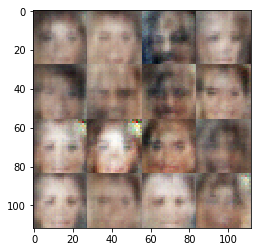

Epoch 0/1 Batch Step 2010... Discriminator Loss: 0.0039... Generator Loss: 9.0337
Epoch 0/1 Batch Step 2020... Discriminator Loss: 0.0136... Generator Loss: 9.3683
Epoch 0/1 Batch Step 2030... Discriminator Loss: 0.0061... Generator Loss: 7.4863
Epoch 0/1 Batch Step 2040... Discriminator Loss: 0.0267... Generator Loss: 13.2171
Epoch 0/1 Batch Step 2050... Discriminator Loss: 0.0078... Generator Loss: 9.4320
Epoch 0/1 Batch Step 2060... Discriminator Loss: 0.0243... Generator Loss: 7.6524
Epoch 0/1 Batch Step 2070... Discriminator Loss: 0.0079... Generator Loss: 10.4450
Epoch 0/1 Batch Step 2080... Discriminator Loss: 0.0072... Generator Loss: 7.5963
Epoch 0/1 Batch Step 2090... Discriminator Loss: 0.0033... Generator Loss: 7.8841
Epoch 0/1 Batch Step 2100... Discriminator Loss: 0.0033... Generator Loss: 7.4631


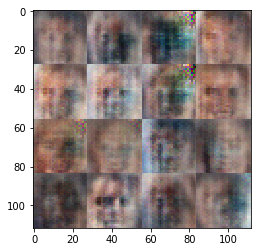

Epoch 0/1 Batch Step 2110... Discriminator Loss: 0.0265... Generator Loss: 7.9239
Epoch 0/1 Batch Step 2120... Discriminator Loss: 0.0285... Generator Loss: 4.8830
Epoch 0/1 Batch Step 2130... Discriminator Loss: 0.0063... Generator Loss: 8.1188
Epoch 0/1 Batch Step 2140... Discriminator Loss: 0.4000... Generator Loss: 1.5217
Epoch 0/1 Batch Step 2150... Discriminator Loss: 0.0071... Generator Loss: 8.9532
Epoch 0/1 Batch Step 2160... Discriminator Loss: 0.0067... Generator Loss: 7.2571
Epoch 0/1 Batch Step 2170... Discriminator Loss: 0.0041... Generator Loss: 7.4691
Epoch 0/1 Batch Step 2180... Discriminator Loss: 0.0065... Generator Loss: 10.4784
Epoch 0/1 Batch Step 2190... Discriminator Loss: 0.0045... Generator Loss: 9.4760
Epoch 0/1 Batch Step 2200... Discriminator Loss: 0.0070... Generator Loss: 6.8915


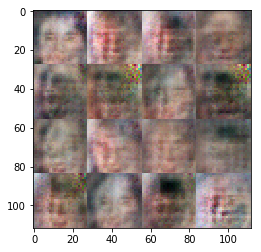

Epoch 0/1 Batch Step 2210... Discriminator Loss: 0.0024... Generator Loss: 8.4845
Epoch 0/1 Batch Step 2220... Discriminator Loss: 0.0185... Generator Loss: 9.3774
Epoch 0/1 Batch Step 2230... Discriminator Loss: 0.0020... Generator Loss: 12.3273
Epoch 0/1 Batch Step 2240... Discriminator Loss: 0.0079... Generator Loss: 9.1119
Epoch 0/1 Batch Step 2250... Discriminator Loss: 0.0049... Generator Loss: 8.2650
Epoch 0/1 Batch Step 2260... Discriminator Loss: 0.0067... Generator Loss: 7.1485
Epoch 0/1 Batch Step 2270... Discriminator Loss: 0.0059... Generator Loss: 6.7590
Epoch 0/1 Batch Step 2280... Discriminator Loss: 0.0023... Generator Loss: 9.3335
Epoch 0/1 Batch Step 2290... Discriminator Loss: 0.0057... Generator Loss: 7.1761
Epoch 0/1 Batch Step 2300... Discriminator Loss: 0.0019... Generator Loss: 9.5630


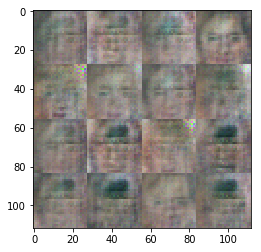

Epoch 0/1 Batch Step 2310... Discriminator Loss: 0.0105... Generator Loss: 6.0060
Epoch 0/1 Batch Step 2320... Discriminator Loss: 0.0050... Generator Loss: 7.7244
Epoch 0/1 Batch Step 2330... Discriminator Loss: 0.0022... Generator Loss: 8.7649
Epoch 0/1 Batch Step 2340... Discriminator Loss: 0.0026... Generator Loss: 9.0140
Epoch 0/1 Batch Step 2350... Discriminator Loss: 0.0096... Generator Loss: 7.7772
Epoch 0/1 Batch Step 2360... Discriminator Loss: 0.0039... Generator Loss: 11.9161
Epoch 0/1 Batch Step 2370... Discriminator Loss: 0.0550... Generator Loss: 3.7576
Epoch 0/1 Batch Step 2380... Discriminator Loss: 0.0024... Generator Loss: 8.3899
Epoch 0/1 Batch Step 2390... Discriminator Loss: 0.0048... Generator Loss: 7.8448


KeyboardInterrupt: 

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.